## ❄️ [Day 7](https://adventofcode.com/2018/day/7)

In [0]:
import collections

def build_dependencies(inputs):
  """Build the graph from the given inputs, getting forward and backward dependencies"""
  dependencies = collections.defaultdict(lambda: [])
  forward = collections.defaultdict(lambda: [])
  for ante, poste in inputs:
    forward[ante].append(poste)
    dependencies[poste].append(ante)
  forward = {k: sorted(v) for k, v in forward.items()}
  leaves = set(dependencies.keys())
  parents = set(forward.keys())
  roots = parents - leaves
  return sorted(list(roots), reverse=True), dependencies, forward

def is_valid(dependencies, path):
  """Check if all dependecies in the list are met from the current path"""
  for k in dependencies:
    if not k in path:
      return False
  return True

def iter_path(path, available, forward, dependencies):  
  """One step iteration to build the path given the current available nodes and dependencies"""
  current_node = available.pop()
  path += current_node
  if current_node in forward:
    for successor in forward[current_node]:
      if is_valid(dependencies[successor], path):
        available.append(successor)
    available = sorted(available, reverse=True)
  return path, available
    
def find_path(inputs):
  """Build the path with 1 worker"""
  path =''
  roots, dependencies, forward = build_dependencies(inputs)
  available = roots          
  while len(available):
    path, available = iter_path(path, available, forward, dependencies)    
  return path    


def get_time(letter, short=False):
  """Get the time needed to execute the task assigned to the given letter. 
  optional short option remove 60s for lighter display"""
  return ord(letter) - 4 - int(short) * 60

def iter_path_parallel(path, available, workers, forward, dependencies, short=False): 
  """One step iteration to build the timedpath given the current available nodes and dependencies"""
  for worker in workers:    
    # If task is in process, remove one unit of time
    if worker['task'] is not None:
      worker['remaining_time'] -= 1  
      # if finished task, reset
      if worker['remaining_time'] == 0: # finish a task
        path += worker['task']
        if worker['task'] in forward:
          for successor in forward[worker['task']]:
            if is_valid(dependencies[successor], path):
              available.append(successor)
          available = sorted(available, reverse=True)
        worker['task'] = None         
    # If worker was or is now free, assign a new task
    if worker['task'] is None:
      if len(available):
        current_node = available.pop()
        worker['task'] = current_node
        worker['remaining_time'] = get_time(current_node, short=short)        
  # Return
  return path, available

def all_workers_finished(workers):
  """Test if all workers are currently idle"""
  for w in workers:
    if w['task'] is not None or w['remaining_time'] > 0:
      return False
  return True

def find_timed_path(inputs, num_workers=5):
  """Build the timed path with n workers"""
  roots, dependencies, forward = build_dependencies(inputs)
  available_workers = [{'task': None, 'remaining_time': 0} for _ in range(num_workers)]
  path = ''
  available = roots
  num_iters = 0
  while len(path) == 0 or not all_workers_finished(available_workers):
    path, available = iter_path_parallel(path, available, available_workers, 
                                         forward, dependencies, short=False)
    num_iters += 1
  return num_iters - 1, path

In [2]:
with open("day7.txt", 'r') as f:
  inputs = [[letter for letter in x if letter.isalpha() and letter == letter.upper()][1:] 
            for x in f.read().splitlines()]
  
  print('Correct order:', find_path(inputs))
print('Time to complete with 5 workers:', find_timed_path(inputs, num_workers=5))

Correct order: SCLPAMQVUWNHODRTGYKBJEFXZI
Time to complete with 5 workers: (1234, 'SCLPAMQVWYNUHODTRGKBJEFXZI')


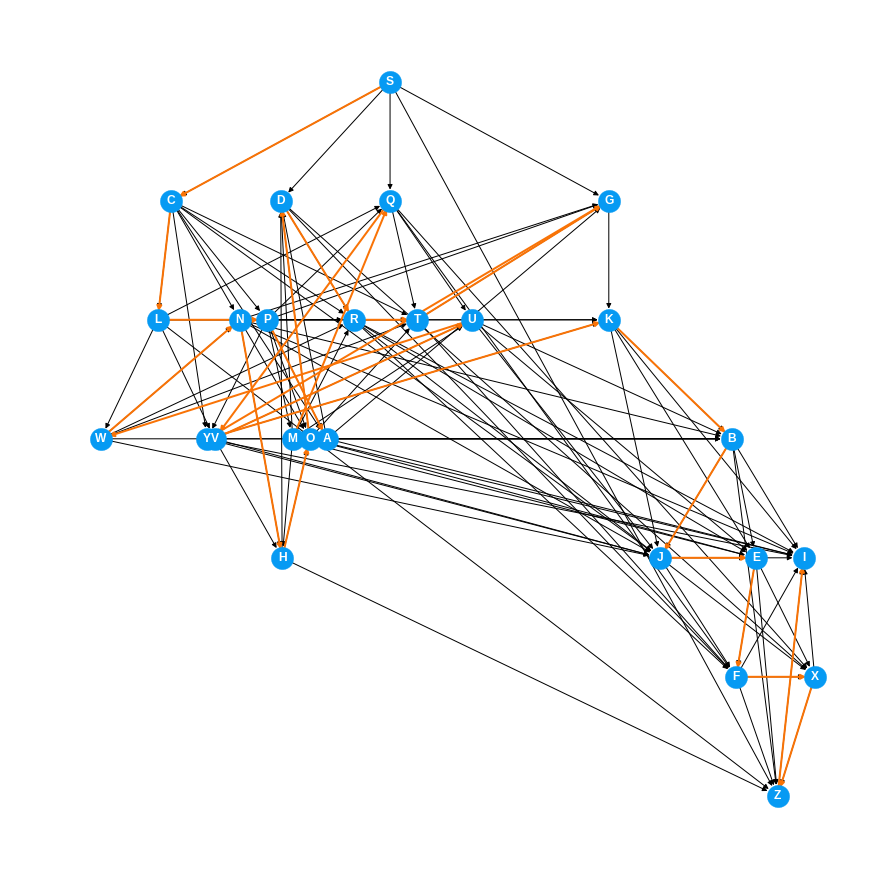

In [3]:
#@title Visualize the graph
import networkx as nx
from matplotlib import pyplot as plt

def hierarchy_pos(G, root, base_width=0.2, width=1.0, vert_gap=0.8, vert_loc=0, xcenter=0.5, pos=None, parent=None):
  """Source: https://stackoverflow.com/questions/29586520/can-one-get-hierarchical-graphs-from-networkx-with-python-3"""
  if pos == None:
      pos = {root:(xcenter,vert_loc)}
  else:
      pos[root] = (xcenter, vert_loc)
  neighbors = list(G.neighbors(root))
  if len(neighbors)!=0:
      dx = width / len(neighbors)
      nextx = xcenter - width/2 - dx/2
      for neighbor in neighbors:
          nextx += dx
          pos = hierarchy_pos(G, neighbor, width=dx + base_width, vert_gap=vert_gap, 
                              vert_loc=vert_loc-vert_gap, xcenter=nextx, pos=pos, 
                              parent=root)
  return pos
  
  
def visualize(inputs, path):
  roots, _, _ = build_dependencies(inputs)
  plt.figure(figsize=(12, 12))
  G = nx.DiGraph()  
  G.add_edges_from(inputs)
  pos = hierarchy_pos(G, roots[0])
  nx.draw(G, pos=pos, arrows=True, with_labels=True, node_size=500, node_color='xkcd:azure',
          font_color='white', font_weight='bold')
  # not accurate because the path does not necessarily follow consecutive node, but works in practice
  nx.draw_networkx_edges(G, pos=pos, edgelist=[[e, path[i + 1]] for i, e in enumerate(path[:-1])], edge_color='xkcd:orange', width=2)
  plt.show()
  
visualize(inputs, 'SCLPAMQVUWNHODRTGYKBJEFXZI')

In [4]:
#@title Visualize the path for timed tasks (with - 60s times)
# Note that this is not exactly equivalent to the version with 60+ seconds 
# But this is much simpler for visualization purposes

def print_workers(second, workers, path):
  print('%06d  ' % second, '  '.join(
      '    %s    ' % (w['task'] if w['task'] is not None else '.')
      for w in workers), ' ', path)
  
def visualize(inputs, num_workers=5, short=True):
  roots, dependencies, forward = build_dependencies(inputs)
  available_workers = [{'task': None, 'remaining_time': 0} for _ in range(num_workers)]
  path = ''
  available = roots
  num_iters = 0
  print('Second -', ' - '.join('Worker %03d' % (k + 1) for k in range(num_workers)), '- Path')
  while len(path) == 0 or not all_workers_finished(available_workers):
    path, available = iter_path_parallel(path, available, available_workers, 
                                         forward, dependencies, short=short)
    print_workers(num_iters, available_workers, path)
    num_iters += 1
    
visualize(inputs, num_workers=5)

Second - Worker 001 - Worker 002 - Worker 003 - Worker 004 - Worker 005 - Path
000000       S          .          .          .          .       
000001       S          .          .          .          .       
000002       S          .          .          .          .       
000003       S          .          .          .          .       
000004       S          .          .          .          .       
000005       S          .          .          .          .       
000006       S          .          .          .          .       
000007       S          .          .          .          .       
000008       S          .          .          .          .       
000009       S          .          .          .          .       
000010       S          .          .          .          .       
000011       S          .          .          .          .       
000012       S          .          .          .          .       
000013       S          .          .          .          .     